# Percolation

**Note:** We say cluster instead of connected component.

In [1]:
# Import libraries
import os
import math
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, Video

import plotly.express as px
import plotly.graph_objects as go

## Percolation plots

In [2]:
random_edge_selector = lambda G : list(G.edges)[random.randint(1, len(G.edges))-1]

def erdos_renyi_percolation(n, lamda):
    '''
        Returns dictionary of (edge number, C/n) pairs 
        where C is the giant cluster
    '''
    p = lamda/n
    G = nx.erdos_renyi_graph(n, p)
    m = len(G.edges)
    edge_to_frac = dict()
    edge_to_cluster_sizes = dict()
    deleted_edges = []

    for edge_num in range(1, m+1):
        # Remove edge
        deleted_edge = random_edge_selector(G)
        deleted_edges.append(deleted_edge)
        G.remove_edges_from([deleted_edge])
    
        # Find max cluster size
        clusters = dict(enumerate(nx.connected_components(G), start=1))
        cluster_sizes = {i : len(clusters[i]) for i in clusters}
        max_cluster_size = max(list(cluster_sizes.values()))
        frac = max_cluster_size / n
    
        # Create dictionaries
        edge_to_frac[m - edge_num] = frac
        edge_to_cluster_sizes[m - edge_num] = max_cluster_size

    return [G, deleted_edges, edge_to_frac, edge_to_cluster_sizes]

In [3]:
def percolation_plot(n, lamda):
    '''
        Generates percolation evolution graph
    '''
    [_, _, edge_to_frac, _] = erdos_renyi_percolation(n, lamda)
    
    r = np.array(list(edge_to_frac.keys())) / n
    frac_array = np.array(list(edge_to_frac.values()))
    
    fig = px.line(x=r, y=frac_array, 
                  title= "$n = {0} \quad \lambda = {1}$".format(n, lamda), 
                  labels={"x" : "r", "y" : "C/n"},
                  range_x=[0, 1.525],
                  range_y=[0, 1.025])
    
    print("\n-----------------")
    print("Percolation plot")
    print("-----------------\n")
    
    fig.show()

In [4]:
def edge_gc_plot(n, lamda):
    '''
        Generates edge to giant cluster size graph
    '''
    G, deleted_edges, _, edge_to_cluster_sizes = erdos_renyi_percolation(n, lamda)
    
    edges = list(edge_to_cluster_sizes.keys())
    sizes = list(edge_to_cluster_sizes.values())
    
    fig = px.line(x=edges, y=sizes, 
                  title= "$n = {0} \quad \lambda = {1}$".format(n, lamda), 
                  labels={"x" : "Edges", "y" : "Giant cluster size"},
                 )
    
    print("\n--------------------------------")
    print("Edge to giant cluster size graph")
    print("--------------------------------")
    
    fig.show()
    
    return G, deleted_edges

In [5]:
def multi_percolation_plot(n, lamda_list):
    '''
        Generates multiple percolation evolution graphs for different values of lamda.
    '''
    edge_to_frac_list = [erdos_renyi_percolation(n, lamda)[2] for lamda in lamda_list]
    r_list = [np.array(list(edge_to_frac.keys())) / n for edge_to_frac in edge_to_frac_list]
    frac_array_list = [np.array(list(edge_to_frac.values())) for edge_to_frac in edge_to_frac_list]
    fig = go.Figure()

    for i in range(len(edge_to_frac_list)):
        fig.add_trace(go.Scatter(x=r_list[i], 
                                 y=frac_array_list[i],
                                 mode='lines',
                                 name="λ = {0}".format(lamda_list[i])))

        fig.update_layout(title="n = {0}".format(n), xaxis_title="r", yaxis_title="C/n")

    fig.show()

In [15]:
lamda_list = [2, 3, 4, 5]

In [16]:
multi_percolation_plot(500, lamda_list)

In [17]:
multi_percolation_plot(1000, lamda_list)

In [18]:
multi_percolation_plot(2000, lamda_list)

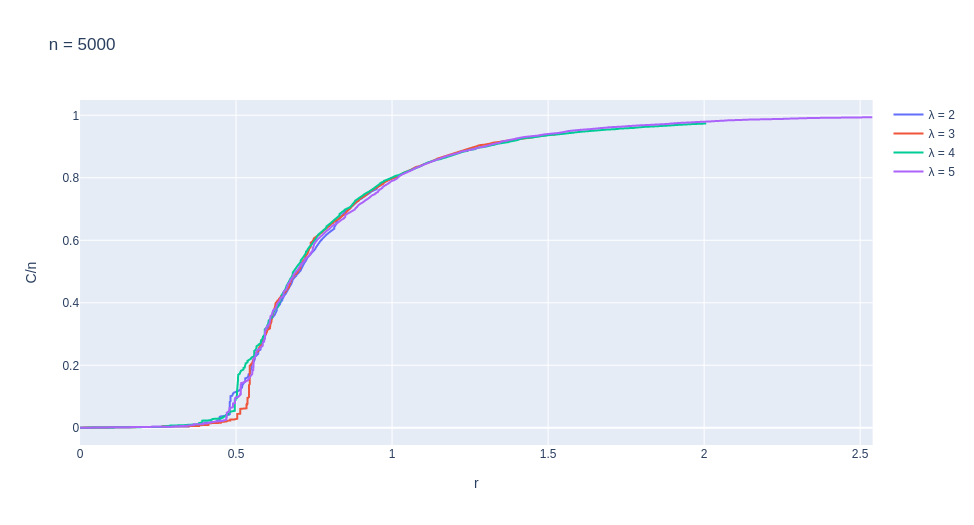

In [19]:
Image(filename='percolation_graphs/5_000.png')

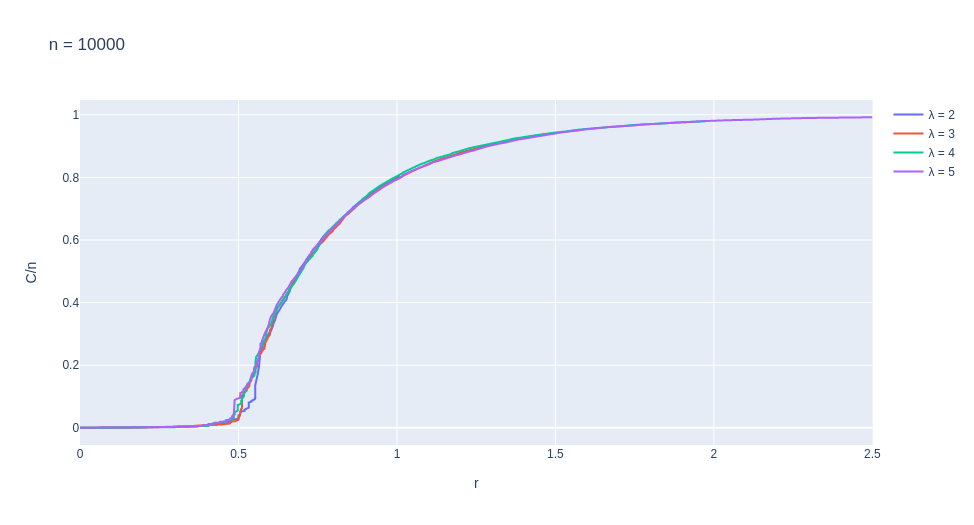

In [20]:
Image(filename='percolation_graphs/10_000.png')

In [21]:
# Image(filename='percolation_graphs/15_000.png')

In [22]:
# Image(filename='percolation_graphs/20_000.png')

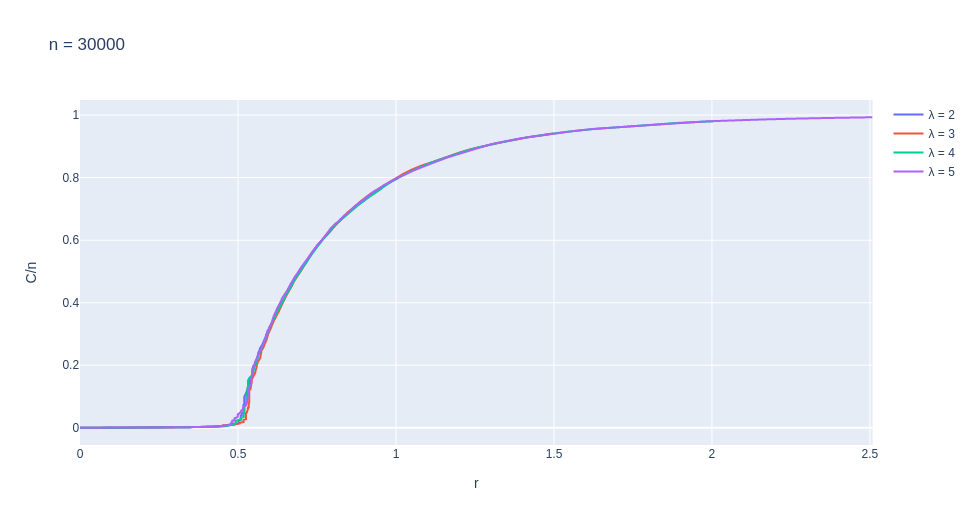

In [23]:
Image(filename='percolation_graphs/30_000.png')

## Percolation animation

In [24]:
def preparation():
    '''
        Initial inputs
    '''
    n = int(input("Input number of vertices = "))
    lamda = int(input("Input λ = "))
    
    G, deleted_edges = edge_gc_plot(n, lamda)
    edge_range = map(int, input("Input range of edge numbers from plot = ").split(','))
    before_index, after_index = edge_range
    
    return n, lamda, G, deleted_edges, before_index, after_index

Input number of vertices = 300
Input λ = 10

--------------------------------
Edge to giant cluster size graph
--------------------------------


Input range of edge numbers from plot = 50, 500


<Figure size 640x480 with 0 Axes>

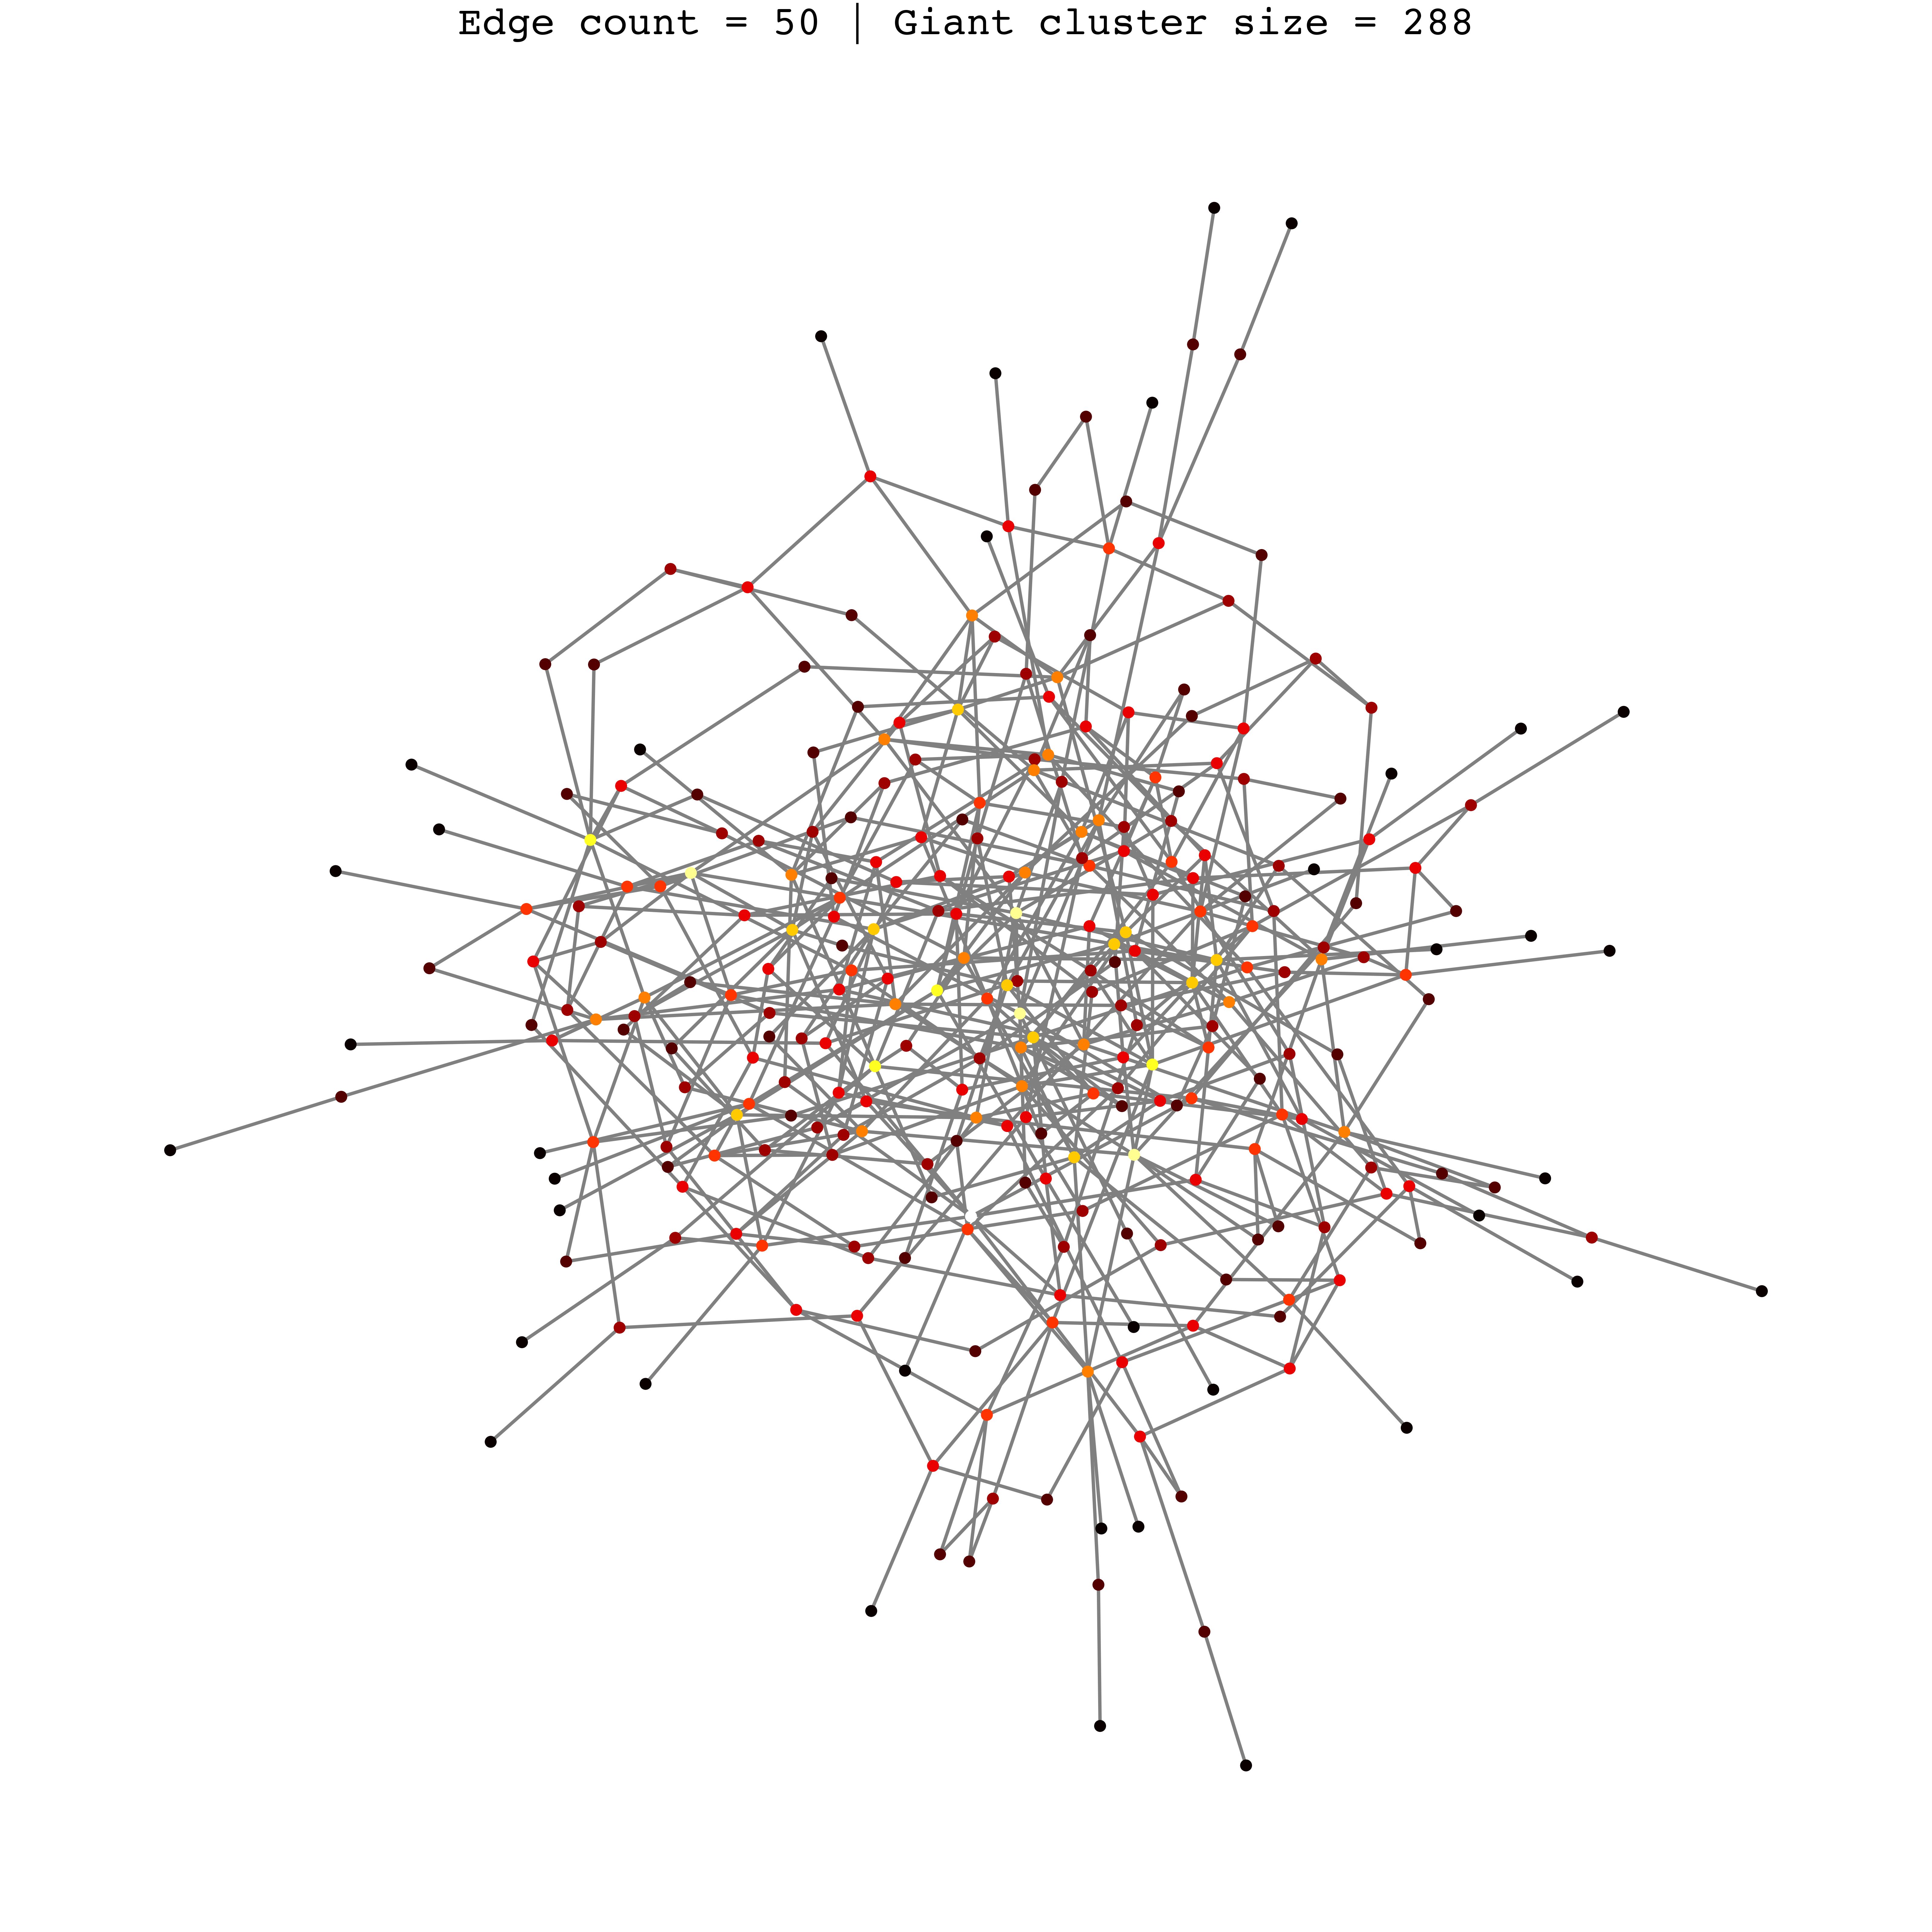

In [26]:
# font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 96}
font = {"fontname": "Courier", "color": "k", "fontsize": 96}

fig = plt.figure()
fig, ax = plt.subplots(figsize=(64, 64))

n, lamda, G, deleted_edges, before_index, after_index = preparation()
total_edges = after_index - before_index + 1

G_new = nx.Graph()
G_new.add_nodes_from(G.nodes())
nx.draw_networkx(G_new, with_labels=False)
G_new.add_edges_from(deleted_edges[:before_index])

def animate(frame):
    
    ax.clear() 
    current_index = before_index + frame
    a, b = deleted_edges[current_index]
    G_new.add_edge(a, b)
    
    clusters = dict(enumerate(nx.connected_components(G_new), start=1))
    cluster_sizes = {i : len(clusters[i]) for i in clusters}
    max_cluster_size = max(list(cluster_sizes.values()))
    
    clusters_nodes = clusters.values()
    avg_cluster_size = np.mean(list(cluster_sizes.values()))
    threshold = 2
    
    shown_nodes = [node for node_set in clusters_nodes for node in node_set if len(node_set) >= threshold]
    shown_edges = [edge for edge in G_new.edges() if edge[0] in shown_nodes and edge[1] in shown_nodes]
    node_degrees = np.array([G_new.degree[node] for node in shown_nodes])
    
    options = {"node_size": 750, "node_color": node_degrees, "nodelist": shown_nodes,
               "edge_color": "grey", "edgelist": shown_edges, "linewidths": 1,
               "width": 8, "cmap": "hot"}
    
    
    ax.set_title("Edge count = " + str(current_index) + " | Giant cluster size = " + str(max_cluster_size), font)
    
    fig.tight_layout()
    ax.set_axis_off()
    nx.draw_networkx(G_new, with_labels=False, **options)
    
anim = animation.FuncAnimation(fig, animate, frames=total_edges, interval=1, repeat=True)
anim.save('percolation.mp4', writer = 'ffmpeg', fps=5)